In [2]:
# De implementar shor usando qiskit 1.3.2
import qiskit
print(qiskit.__version__)

1.3.2


In [1]:
import os
import math
import importlib.util
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Global variable to store the dictionary, loaded only once
loaded_dictionary = None

def clear_circuit():
    """Clears any previous circuit before generating a new one."""
    global circuit
    circuit = None

def load_dictionary(filename):
    """Loads the 'semiprimes' dictionary from an external Python file only once."""
    global loaded_dictionary

    if loaded_dictionary is not None:
        return loaded_dictionary  # Return the dictionary if it's already loaded

    if not os.path.exists(f"{filename}.py"):
        print(f"Error: The file '{filename}.py' was not found.")
        return None
    
    spec = importlib.util.spec_from_file_location(filename, f"{filename}.py")
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    
    loaded_dictionary = getattr(module, "semiprimes", None)  # Store in global variable
    if loaded_dictionary is None:
        print(f"Error: The file '{filename}.py' does not contain 'semiprimes'.")
    
    return loaded_dictionary

def generate_circuits(filename, final_number):
    """
    Generates Qiskit circuits based on the values in the 'semiprimes' dictionary.
    
    Args:
        filename: Name of the Python file containing the dictionary.
        final_number: Last key to consider in the dictionary.
    """
    clear_circuit()
    dictionary = load_dictionary(filename)
    
    if dictionary is None:
        print("Error: Could not load the dictionary.")
        return
    
    global circuit
    for key in range(0, final_number + 1):
        if key not in dictionary:
            continue
        try:
            n = math.ceil(math.log2(dictionary[key]))
            num_qubits = 2 * n + 1
            source_qubits = QuantumRegister(n-1, 'source')
            target_qubits = QuantumRegister(n, 'target')
            #classical_reg = ClassicalRegister(num_qubits, 'c')
            circuit = QuantumCircuit(source_qubits, target_qubits)

        except Exception as e:
            print(f"Unexpected error when generating the circuit for key {key}: {e}")
    
    return circuit

In [2]:
dictionary_key = 3
qc = generate_circuits("semiprimes", dictionary_key)
print(loaded_dictionary[dictionary_key])

15


In [3]:
import random
from math import gcd
#Classic
def choose_coprime(n):
    """
    Efficiently selects a random 'a' that is coprime to n.

    Args:
        n: The integer to find a coprime with.

    Returns:
        A random integer 'a' such that 1 <= a < n and gcd(a, n) == 1.

    Raises:
        ValueError: If n is less than or equal to 1.
        RuntimeError: If a coprime is not found after a certain number of attempts.
    """
    if n <= 1:
        raise ValueError("n must be greater than 1")

    # If n is even, we only generate odd numbers for 'a'
    if n % 2 == 0:
        a = random.randint(2, n - 1)
        if a % 2 == 0:
            a += 1  # Ensure 'a' is odd
    else:
        a = random.randint(2, n - 1)

    # Limit the number of attempts to avoid infinite loops in extreme cases
    max_attempts = 1000
    for _ in range(max_attempts):
        if gcd(a, n) == 1:
            return a
        # Generate a new 'a', avoiding previously tried numbers
        a = random.randint(2, n - 1)
        if n % 2 == 0 and a % 2 == 0:
            a += 1  # Ensure 'a' is odd if n is even

    raise RuntimeError(f"Could not find a coprime 'a' with {n} after {max_attempts} attempts")

l = choose_coprime(loaded_dictionary[dictionary_key]) # coprimes==gdc(a,n)== 1 always

print(l)

14


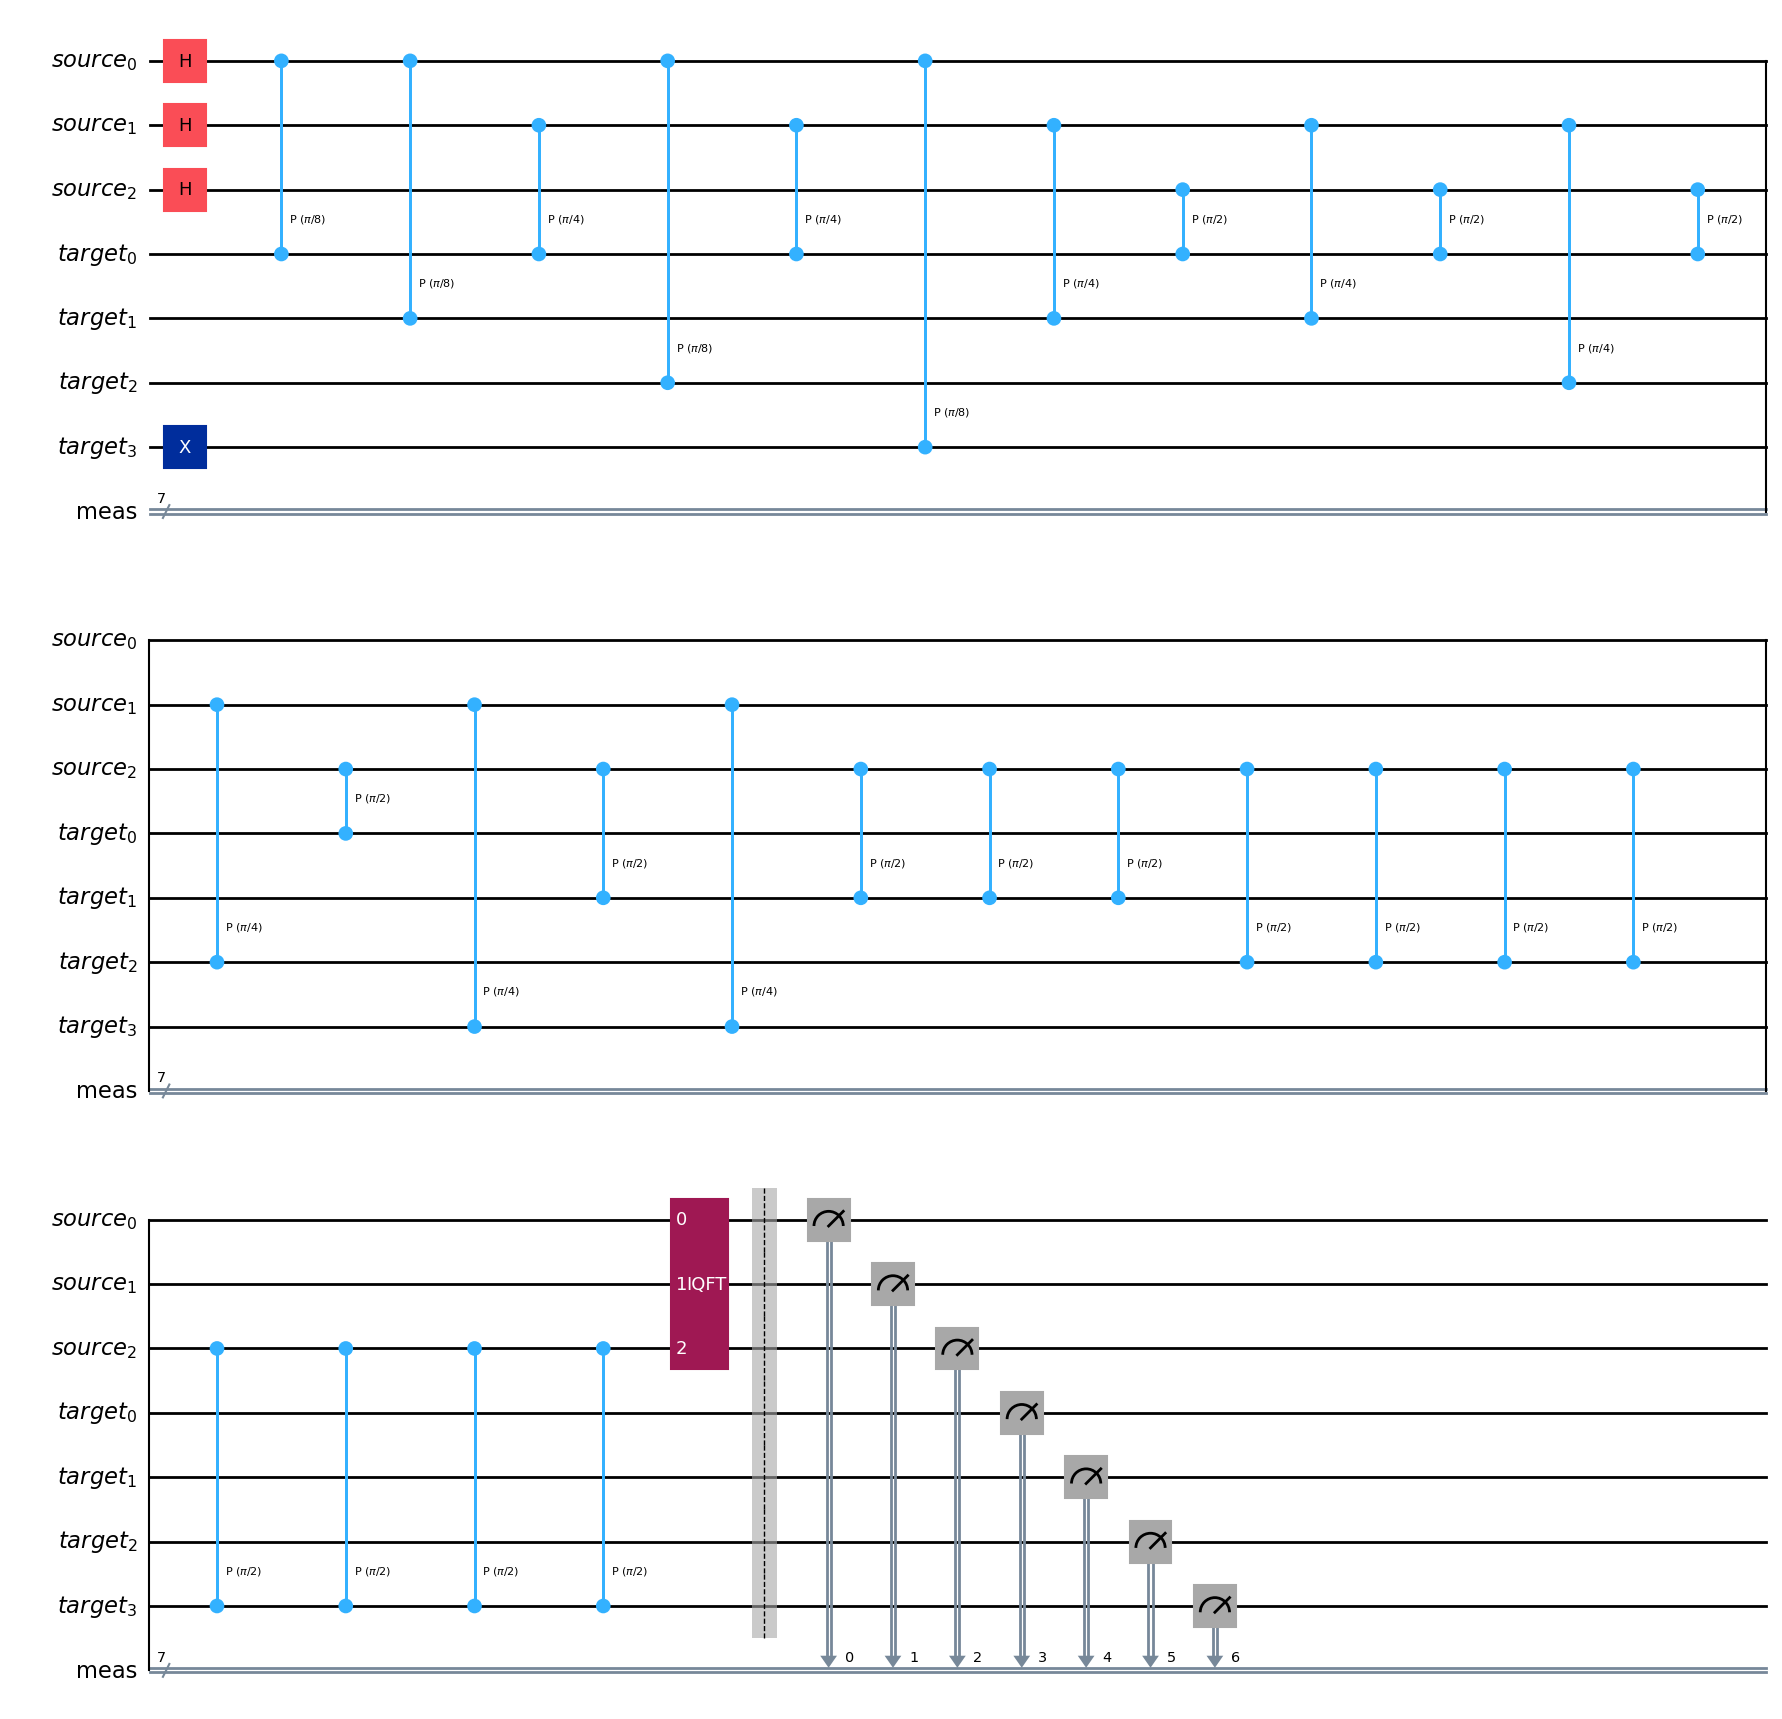

In [ ]:
import math
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT


# Hadamard gates en los qubits de conteo
for qubit in range(dictionary_key):  
    qc.h(qubit)

qc.x(2*dictionary_key)  # Inicializa el último qubit en |1⟩
qc.barrier

# Hacer las operaciones controladas-U:
repetitions = 1

for i in range(dictionary_key):  # Recorre los qubits de conteo
    angle = math.pi / (2 ** (dictionary_key - i))
    
    for j in range(dictionary_key + 1):  # Aplica la operación en cada qubit destino
        for _ in range(repetitions):
            qc.cp(angle, i, dictionary_key + j)  # Aplica CP desde el qubit de conteo i al destino j

    repetitions *= 2  # Duplicar las repeticiones en cada iteración



# Aplicar QFT inverso
qc.append(QFT(dictionary_key, inverse=True), range(dictionary_key))

qc.measure_all()

# Mostrar el circuito
qc.draw(output='mpl')


In [ ]:
# De enviar el trabajo a QuantumRings
import QuantumRingsLib
from QuantumRingsLib import QuantumRegister, AncillaRegister, ClassicalRegister, QuantumCircuit
from QuantumRingsLib import QuantumRingsProvider
from QuantumRingsLib import job_monitor
from QuantumRingsLib import JobStatus
from matplotlib import pyplot as plt
import numpy as np


  
provider = QuantumRingsProvider(
    token='rings-200.GSaGXDXOtdKOK7LxQMUeyJdQvay8kBLJ',
    name='scruzt1300@alumno.ipn.mx'
)
backend = provider.get_backend("scarlet_quantum_rings")

shots = 1024

provider.active_account()





{'name': 'scruzt1300@alumno.ipn.mx',
 'token': 'rings-200.GSaGXDXOtdKOK7LxQMUeyJdQvay8kBLJ',
 'max_qubits': '200'}

In [ ]:
# Execute the circuit
job = backend.run(qc, shots=shots)
job_monitor(job)
result = job.result()
counts = result.get_counts()

#clean up
del q, c, qc
del result
del job